In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from typing import Tuple, List, Optional
from dataclasses import dataclass
from functools import partial

In [39]:
@dataclass
class Gaussian:
    mean: np.ndarray
    cov: np.ndarray

@dataclass
class Observations:
    times: np.ndarray
    obs_ind: np.ndarray  # index of times that are observed
    obs: np.ndarray
    names: List[str]

@dataclass
class KFTracker:
    means: np.ndarray
    covs: np.ndarray
    stds: np.ndarray

In [40]:
def resample(Nsamples, samples, weights):
    """Generate *Nsamples* samples from an empirical distribution defined by *samples* and *weights*

    Inputs
    ------
    Nsamples: integer, number of samples to generate
    samples: (N, d) array of N samples of dimension d that form the empirical distribution
    weights: (N, ) array of N weights

    Returns
    --------
    samples_out: (Nsamples, d) new samples
    weights_out: (Nsamples, ) new weights equal to 1 / N
    """

    N = weights.shape[0]  # get number of points that make up the empirical distribution
    
    # Randomly choose the integers (with replacement) between 0 to N-1 with probabilities given by the weights
    samp_inds = np.random.choice(np.arange(N), Nsamples, p=weights)

    # subselect the samples chosen
    samples_out = samples[samp_inds, :]

    # return uniform weights
    weights_out = np.ones((Nsamples))/Nsamples
    return samples_out, weights_out

In [41]:
def compute_mean_std(samples, weights):
    """Compute the mean and standard deviation of multiple empirical distirbution.

    Inputs
    ------
    samples: (N, d, m) array of samples defining the empirical distribution
    weights: (N, m) array of weights

    Returns
    -------
    means: (m, d) array of means
    stds: (m, d) array of standard deviations

    Notes
    -----
    m is the number of empirical distributions
    """

    N, d, m = samples.shape
    means = np.zeros((m, d))
    stds = np.zeros((m, d))
    for ii in range(m):
        means[ii, :] = np.dot(weights[:, ii], samples[:, :, ii])
        stds[ii, :] = np.sqrt(np.dot(weights[:, ii], (samples[:, :, ii] - np.tile(means[ii, :], (N, 1)))**2))
    return means, stds

In [42]:
def pendulum_dyn(current_state, dt=0.1):

    """Pendulum dynamics

    Inputs
    ------
    Current_state : either (2,) or (N, 2) for vectorized input
    """
    if current_state.ndim == 1:
        next_state = np.zeros((2))
        next_state[0] = current_state[0] + dt * current_state[1]
        next_state[1] = current_state[1] - dt * 9.81 * np.sin(current_state[0])
    else: # multiple inputs
        next_state = np.zeros(current_state.shape)
        next_state[:, 0] = current_state[:, 0] + dt * current_state[:, 1]
        next_state[:, 1] = current_state[:, 1] - dt * 9.81 * np.sin(current_state[:, 0])
    return next_state

def observe(current_state):
    if current_state.ndim == 1:
        out = np.zeros((1))
        out[0] = np.sin(current_state[0])
    else:
        out = np.zeros((current_state.shape[0], 1))
        out[:, 0] = np.sin(current_state[:, 0])
    return out

In [43]:
def step(prop, proppdf, current_samples, current_weights, likelihood, data, propagator, dt, Lproc, proc_var, proc_mat_inv, noise_var):
    """
    Propagate a particle filter

    Inputs
    --------
    prop            - proposal function (current_state, data)
    proppdf         - proposal function logpdf
    current_samples - ensemble of samples
    current_weights - ensemble of weights
    likelihood      - function to evaluate the log likelihood (samples, data)
    data            - Observation
    propagator      - dynamics logpdf

    @returns samples and weights after assimilating the data
    """

    new_samples = prop(current_samples, dt, data, Lproc)
    new_weights = likelihood(new_samples, data, noise_var) + propagator(new_samples, current_samples, dt, data, proc_var, proc_mat_inv) - \
                            proppdf(new_samples, current_samples, dt, data, proc_var, proc_mat_inv)
    
    log_weights = new_weights + np.log(current_weights)
    max_log_weight = np.max(log_weights)
    log_weights -= max_log_weight 
    weights = np.exp(log_weights)
    new_weights = weights / np.sum(weights)
    
    return new_samples, new_weights

In [44]:
def particle_filter(data, prior_mean, prior_cov,
                    prop, proppdf, likelihood, propagator, dt, Lproc, proc_var, proc_mat_inv, noise_var,
                    nsamples=1000, resampling_threshold_frac=0.1):
    
    """Particle Filter

    Inputs
    -------
    data: (nsteps, m) array of data points, N is the time index, m is the dimensionality of the data
    prior_mean: (d), prior mean
    prior_cov: (d, d), prior mean
    Nsamples: integer, number of samples in the empirical distribution
    resampling_threshold_frac: float between 0 and 1 indicating to resample when effective sample size below frac of nsamples

    Returns
    -------
    samples: (nsamples, d, nsteps)
    weights: (nsamples, nsteps)
    eff: (nsamples), effective sample size

    Notes
    -----
    For documentation of prop, proppdf, likelihood, and propagator -- see the step function
    """
    
    d = prior_mean.shape[0]
    nsteps = data.shape[0]

    # Allocate memory
    samples = np.zeros((nsamples, d, nsteps+1))
    weights = np.zeros((nsamples, nsteps+1))
    eff = np.zeros((nsteps+1)) # keep track of effective sample size at each step


    # Generate initial samples from the prior
    L = np.linalg.cholesky(prior_cov)
    samples[:, :, 0] = np.tile(prior_mean, (nsamples, 1))+ np.dot(L, np.random.randn(d, nsamples)).T
    weights[:, 0] = 1.0 / nsamples # all weights are equal because of independent sampling from prior
    eff[0] = nsamples

    resamp_threshold = int(nsamples * resampling_threshold_frac)

    for ii in range(1, nsteps+1):
        samples[:, :, ii], weights[:, ii] = step(prop,  proppdf, samples[:, :, ii-1], weights[:, ii-1],
                                                 likelihood, data[ii-1, :], propagator, dt, Lproc, proc_var, proc_mat_inv, noise_var)

        #weights[:, ii] = normalise(weights[:, ii])

        # compute the effective sample size
        eff[ii] = 1.0 / np.sum(weights[:, ii]**2)

        if ii % 50 == 0:
            print("eff = ", ii, eff[ii])

        # resample if effective sample size is below threshold
        if eff[ii] < resamp_threshold:
            samples[:, :, ii], weights[:, ii] = resample(nsamples, samples[:, :, ii], weights[:, ii])


    return samples, weights, eff

In [45]:
def proposal(current_state, dt, data, Lproc):
    """ Bootstrap Particle Filter the proposal is the dynamics!"""

    if current_state.ndim == 1:
        return pendulum_dyn(current_state, dt) + np.dot(Lproc, np.random.randn(2))
    else:
        nsamples = current_state.shape[0]
        return pendulum_dyn(current_state, dt) + np.dot(Lproc, np.random.randn(2, nsamples)).T

def proposal_logpdf(current, previous, dt, data, proc_var, proc_mat_inv):
    """ Bootstrap Particle Filter: the proposal is the dynamics"""
    nexts  = pendulum_dyn(previous, dt)
    delta = nexts - current
    if current.ndim == 1:
        return -0.5 * np.dot(delta, np.dot(proc_mat_inv, delta))
    else:
        return -0.5 * np.sum(delta * np.dot(delta, proc_mat_inv.T), axis=1)

def likelihood(state, data, noise_var):
    """Gaussian Likelihood through nonlinear model"""
    dpropose = observe(state)
    delta = dpropose - data
    if state.ndim == 1:
        return -0.5 * np.dot(delta, delta) / noise_var
    else:
        return -0.5 * np.sum(delta * delta, axis=1) / noise_var

## Individual Analysis

## Combined Analysis

eff =  50 99114.35598409697
eff =  100 98310.97810733972
eff =  50 12854.348181069561
eff =  100 99974.971034295
eff =  50 3.99060766636634
eff =  100 2470.6598428611856
eff =  50 1.0
eff =  100 1.0
eff =  50 61174.095535421344
eff =  50 86772.63102073531
eff =  50 17963.625689074648
eff =  50 1.2571258452699907


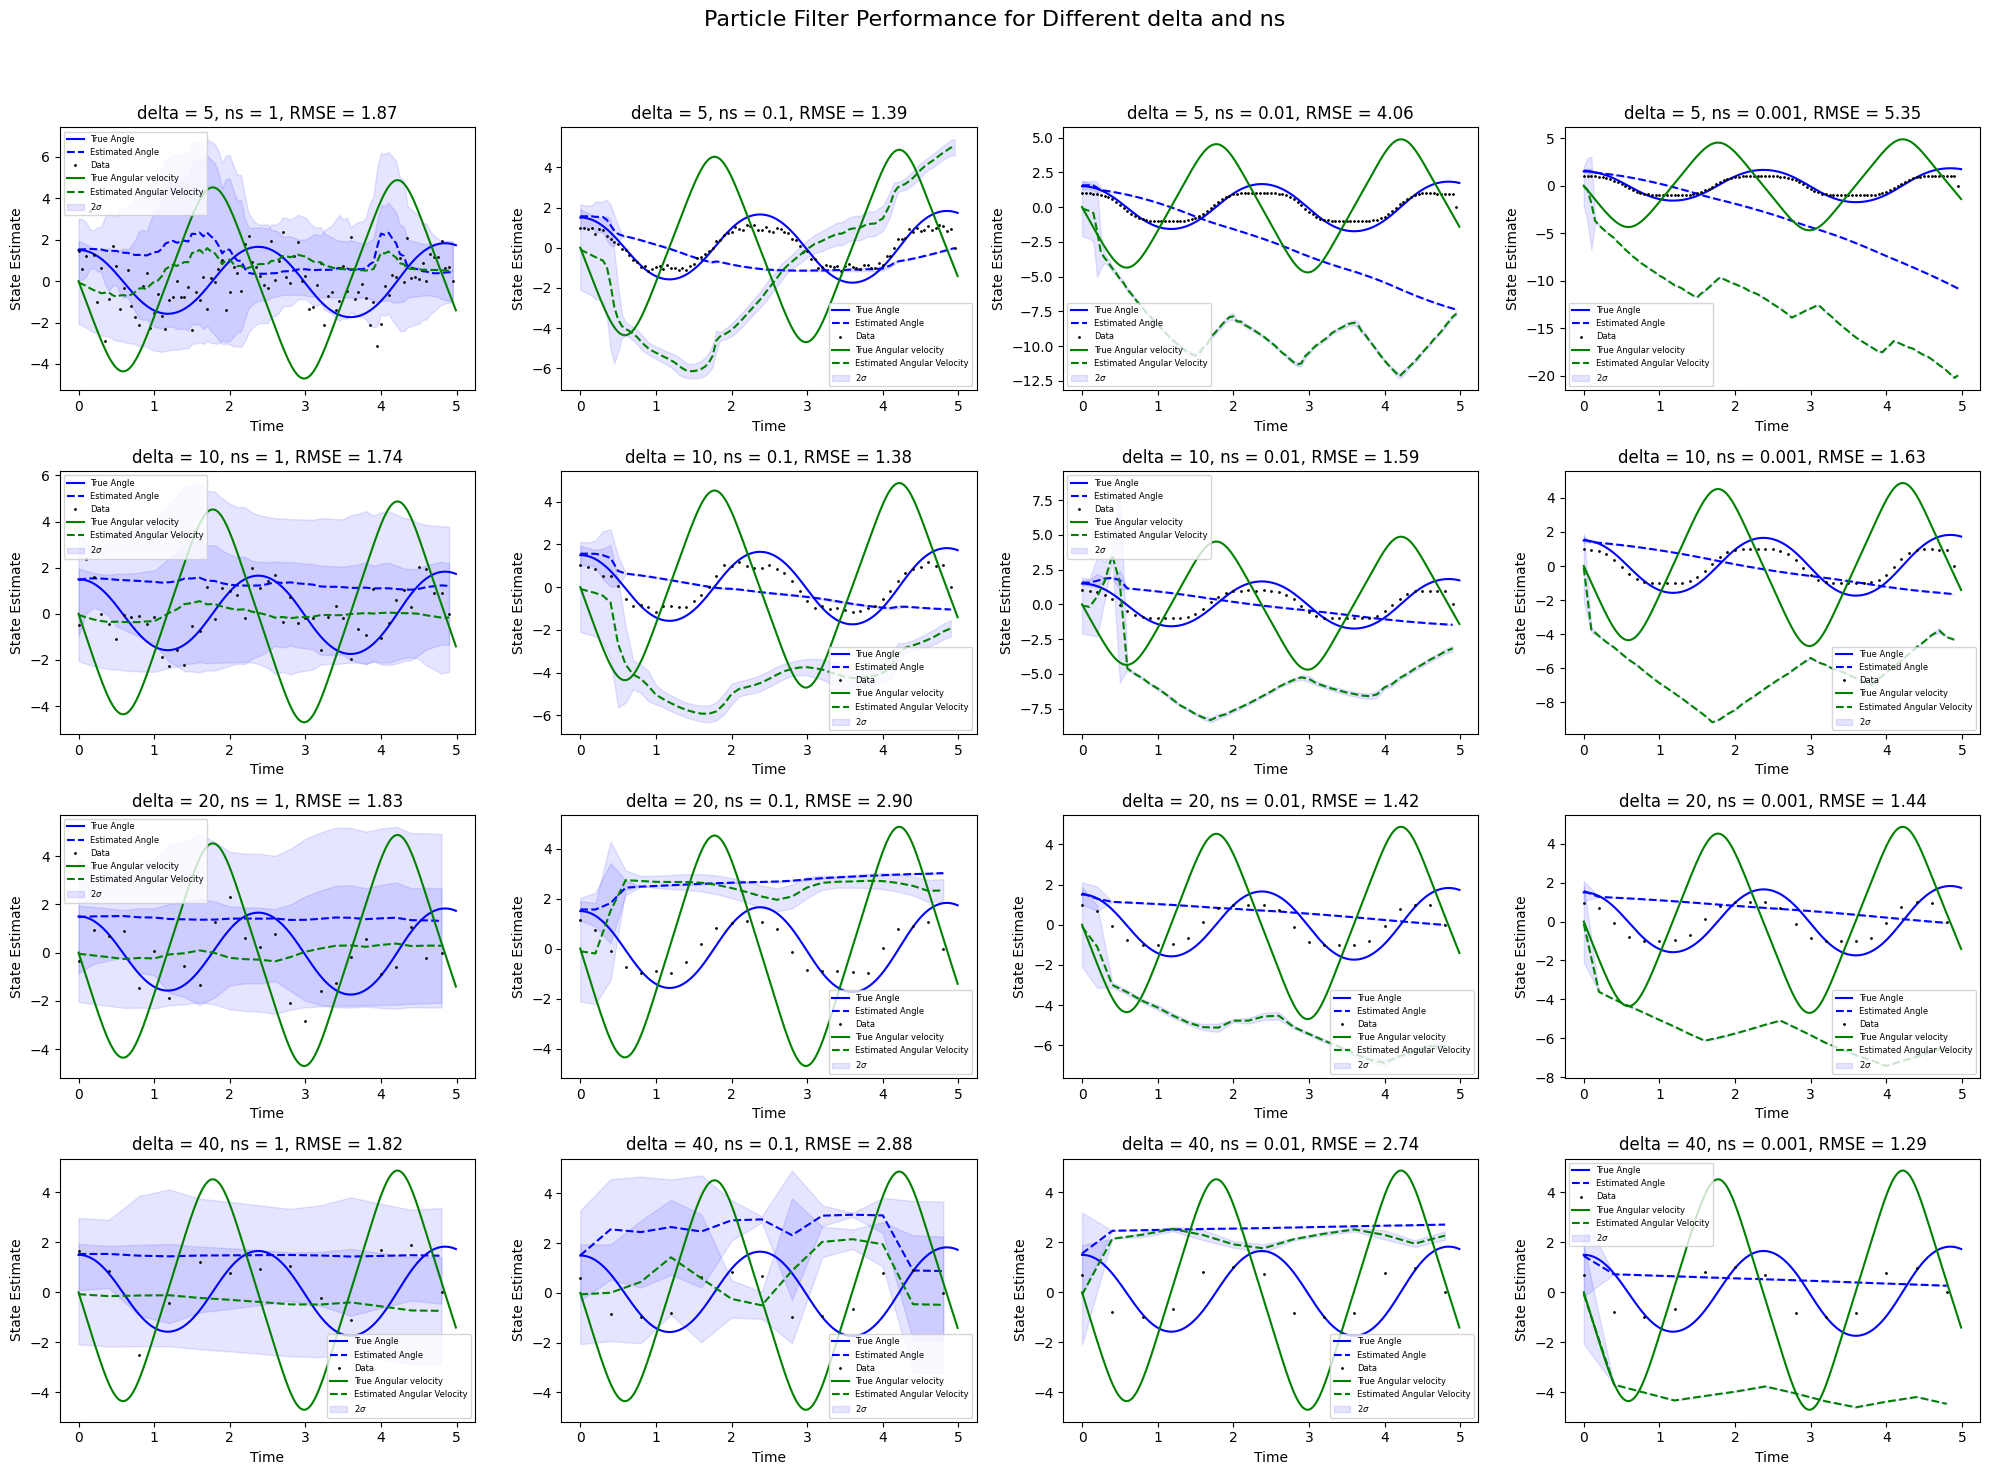

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
x0 = np.array([1.5, 0])  # Initial state
dt = 0.01  # Time step
Nsteps = 500  # Number of time steps
times = np.arange(0, Nsteps*dt, dt)  # Time array
num_samples = 100000  # Number of particles
resample_thresh = 0.5  # Resampling threshold
proc_var = 0.5  # Process noise variance

# Initialize process noise covariance matrix
proc_mat = np.zeros((2, 2))
proc_mat[0, 0] = proc_var / 3.0 * dt**3
proc_mat[0, 1] = proc_var / 2.0 * dt**2
proc_mat[1, 0] = proc_var / 2.0 * dt**2
proc_mat[1, 1] = proc_var * dt
proc_mat_inv = np.linalg.pinv(proc_mat)
Lproc = np.linalg.cholesky(proc_mat)

# Combinations of delta and ns
delta_values = [5, 10, 20, 40]
ns_values = [1, 0.1, 0.01, 0.001]

# Prepare the plot
fig, axs = plt.subplots(len(delta_values), len(ns_values), figsize=(20, 15))
fig.suptitle("Particle Filter Performance for Different delta and ns", fontsize=16)

# Loop over delta and ns
for i, delta in enumerate(delta_values):
    for j, ns in enumerate(ns_values):
        noise_var = ns * ns  # Variance of observation noise
        obs_ind = np.arange(0, Nsteps, delta)  # Observation indices
        data = np.zeros((len(obs_ind), 1))  # Observed data

        # Generate truth and observations
        true = np.zeros((Nsteps, 2))
        true[0, :] = x0
        obs_counter = 0

        for ii in range(1, Nsteps):
            true[ii, :] = pendulum_dyn(true[ii-1, :], dt=dt)
            if ii in obs_ind:
                data[obs_counter] = observe(true[ii, :]) + np.random.randn() * ns
                obs_counter += 1

        # Run particle filter
        samples, weights, eff = particle_filter(
            data, true[0, :], np.eye(2), proposal, proposal_logpdf,
            likelihood, proposal_logpdf, dt, Lproc, proc_var, proc_mat_inv,
            noise_var, nsamples=num_samples, resampling_threshold_frac=resample_thresh
        )
        means, stds = compute_mean_std(samples, weights)

        # Compute RMSE
        RMSE = np.sqrt(np.mean((means[1:, 0] - true[obs_ind, 0])**2))

        # Plot results
        ax = axs[i, j]
        ax.plot(times, true[:, 0], 'b-', label='True Angle')
        ax.plot(times[obs_ind], means[1:, 0], 'b--', label='Estimated Angle')
        ax.plot(times[obs_ind], data[:, 0], 'ko', ms=1, label='Data')
        ax.fill_between(times[obs_ind],
                        means[1:, 0] - 2 * stds[1:, 0],
                        means[1:, 0] + 2 * stds[1:, 0],
                        color='blue', alpha=0.1)

        ax.plot(times, true[:, 1], 'g-', label='True Angular velocity')
        ax.plot(times[obs_ind], means[1:, 1], 'g--', label='Estimated Angular Velocity')
        ax.fill_between(times[obs_ind],
                        means[1:, 1] - 2 * stds[1:, 1],
                        means[1:, 1] + 2 * stds[1:, 1],
                        color='blue', alpha=0.1, label=r'$2\sigma$')

        ax.set_title(f"delta = {delta}, ns = {ns}, RMSE = {RMSE:.2f}")
        ax.set_xlabel("Time")
        ax.set_ylabel("State Estimate")
        ax.legend(fontsize=6)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()